# DialoGPT fine-tuning Chatbot

Adapted from [Nathan Cooper finetuning Dialogflow](https://nathancooper.io/i-am-a-nerd/chatbot/deep-learning/gpt2/2020/05/12/chatbot-part-1.html).


## Step zero

In [1]:
import shutil

# delete redundant files left previously (at last time of training)
file_paths = ['./cached', './runs', './large-chatbot', './large-sandbox', './model_chatbot', './model_sandbox', './model']
for i in range(len(file_paths)):
    try:
        shutil.rmtree(file_paths[i])
    except FileNotFoundError:
        print('No dir path called '+file_paths[i]+', no need to delete.')


No dir path called ./large-chatbot, no need to delete.
No dir path called ./large-sandbox, no need to delete.
No dir path called ./model_sandbox, no need to delete.
No dir path called ./model, no need to delete.


In [2]:
import os
import torch

os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'   # close oneDNN optimization

print(f"Number of GPUs: {torch.cuda.device_count()}")
# List info of all available GPUs
gpu_info = []
for i in range(torch.cuda.device_count()):
    gpu_details = {
        "Name": torch.cuda.get_device_name(i),
        "Capability": torch.cuda.get_device_capability(i),
        "Memory Allocated": f"{torch.cuda.memory_allocated(i) / (1024 ** 3):.2f} GB",
        "Memory Cached": f"{torch.cuda.memory_reserved(i) / (1024 ** 3):.2f} GB",
        "Total Memory": f"{torch.cuda.get_device_properties(i).total_memory / (1024 ** 3):.2f} GB"
    }
    gpu_info.append(gpu_details)

print(gpu_info)

print(f"Number of CPUs: {os.cpu_count()}")
        
''' Synthesis data '''
# %run generate_dataset.py

Number of GPUs: 1
[{'Name': 'NVIDIA A100 80GB PCIe', 'Capability': (8, 0), 'Memory Allocated': '0.00 GB', 'Memory Cached': '0.00 GB', 'Total Memory': '79.32 GB'}]
Number of CPUs: 96


' Synthesis data '

## Set up drive

In [3]:
# offer pre-trained models for: classification, extraction, dialogue
!pip -q install transformers
# create interactive HTML components (e.g. button) in Jupitor
!pip install ipywidgets
# ensure 'ipywidgets' can be used
!jupyter nbextension enable --py widgetsnbextension  

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [4]:
!ls

chatbot  DialoGPT_finetuning_Chatbot.ipynb


In [4]:
# Tokenizer is to change texts into the form which can be understood by LLM
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

tokenizer = AutoTokenizer.from_pretrained("microsoft/DialoGPT-large", padding_side='left')
model = AutoModelForCausalLM.from_pretrained("microsoft/DialoGPT-large")

In [7]:
!pip install nvidia-tensorrt

''' Prepare the env for NLP.
Package for:  File operation: glob, os, shutil;  Normalization: re;  Data analysis: pandas, numpy;  DL: torch, sklearn;
Data load & batch: DataLoader, Dataset, RandomSampler, SequentialSampler, DistributedSampler '''

from transformers import (
    WEIGHTS_NAME,
    # a kind of optimaizational algorithm for training model
    AdamW,
    AutoConfig,
    AutoModelForCausalLM,
    AutoTokenizer,
    PreTrainedModel,
    PreTrainedTokenizer,
    get_linear_schedule_with_warmup,
)
import glob
import logging
import os
import pickle
import random
import re
import shutil
import json
from typing import Dict, List, Tuple
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset, RandomSampler, SequentialSampler
from torch.utils.data.distributed import DistributedSampler
from tqdm.notebook import tqdm, trange
from pathlib import Path

# try to import
try:
    from torch.utils.tensorboard import SummaryWriter
except ImportError:
    from tensorboardX import SummaryWriter

# Configs. Log is convenient for debugging & tracking
# __name__ means each module can has its own logger instance 
logger = logging.getLogger(__name__)

In [8]:
''' ---------  Set up training type (for Chatbot or Sandbox)  --------- '''

#output_dir = 'model_sandbox'
output_dir = 'model_chatbot'
#datasets_dir = 'sandbox'
datasets_dir = 'chatbot'

train_data = datasets_dir + '/train_data.json'
validate_data = datasets_dir + '/validate_data.json'
test_data = datasets_dir + '/test_data.json'

In [9]:
# Args to allow for easy convertion of python script to notebook
class Args():
    def __init__(self):
        self.output_dir = output_dir
        self.model_type = 'gpt2'
        self.model_name_or_path = 'microsoft/DialoGPT-large'
        self.config_name = 'microsoft/DialoGPT-large'
        self.tokenizer_name = 'microsoft/DialoGPT-large'
        self.cache_dir = 'cached'                        # path to download & cache model
        self.block_size = 512
        # train & eval or not?
        self.do_train = True
        self.do_eval = True
        self.evaluate_during_training = False   # eval after training finished
        self.per_gpu_train_batch_size = 2
        self.per_gpu_eval_batch_size = 2
        self.gradient_accumulation_steps = 1
        self.learning_rate = 5e-5
        self.weight_decay = 0.0
        self.adam_epsilon = 1e-8
        self.max_grad_norm = 1.0
        self.num_train_epochs = 4
        self.max_steps = -1             # '-1' means the max of steps is unlimited
        self.warmup_steps = 0
        self.logging_steps = 1000    # distance between log records
        self.save_steps = 3500
        self.save_total_limit = None         # max num of saved checkpoints, the old ones would be deleted once exceed
        self.eval_all_checkpoints = False
        self.no_cuda = not torch.cuda.is_available()    # use CUDA (aka GPU) or not?
        self.overwrite_output_dir = True
        self.overwrite_cache = True
        self.should_continue = False     # restart training from the last checkpoint?
        self.seed = 42                  # random seed
        self.local_rank = -1
        self.fp16 = False               # use 16-bit float to train?
        self.fp16_opt_level = 'O1'
        ''' fp16_opt_level is a param in NVIDIA Apex Mixed precision training, 
        by default 01: switch between fp32 and fp16, to balance the computing speed and model precision.
        00: pure fp32 without opt, for very high model precision requirement.
        02: almost pure fp16 
        03: pure fp16, fastest, but sacrifice in model precision '''

args = Args()

## Preprocess dataset

In [10]:
f_train = open(train_data)
train_data = json.load(f_train)
# close() can avoid resource leaking
f_train.close()
print(len(train_data))


f_validate = open(validate_data)
validate_data = json.load(f_validate)
f_validate.close()
print(len(validate_data))

4361
1246


In [11]:
train_contexted = []
 
for i in range(len(train_data)):
  row = []
  row.append(train_data[i][1])
  row.append(train_data[i][0])
  train_contexted.append(row)

In [12]:
validate_contexted = []

for i in range(len(validate_data)):
  row = []
  row.append(validate_data[i][1])
  row.append(validate_data[i][0])
  validate_contexted.append(row)  

In [13]:
columns = ['response', 'context'] 
columns = columns + ['context/'+str(i) for i in range(0)]
columns

['response', 'context']

In [17]:
len(train_contexted)
trn_df = pd.DataFrame.from_records(train_contexted, columns=columns)
trn_df.head(5)

,response,context
0,"Based on the client's income and balance, this...",Does this individual have chance to invest in ...
1,Without knowing the monthly earnings and bank ...,"Considering the options available, is Ping An ..."
2,This investment idea could be too risky for th...,What if one buys Guang Da Currency Fund B sinc...
3,"According to evaluating, I think Nong Ye Stock...",Given that I earn approximately 79691.4079691....
4,I suggest avoiding this investment. It's too r...,"Considering my current salary (7465.83 rmb), w..."


In [18]:
len(validate_contexted)
# turn a List into a DataFrame
val_df = pd.DataFrame.from_records(validate_contexted, columns=columns)
val_df.head(5)

,response,context
0,"This is a good choice in my view, the return v...",What if I invest on Ping An Currency Fund A si...
1,"Yes, I think Jian She Accidental Insurance B f...",If my monthly salary is 162809.20yuan/month an...
2,This investment appears too risky for the clie...,Thinking for the current salary and savings ba...
3,There aren't any products with enough safty al...,Give suggestions about this: With 12132 yuan a...
4,The client may want to avoid this investment s...,"If earning RMB19109.17 per month, with 15385 y..."


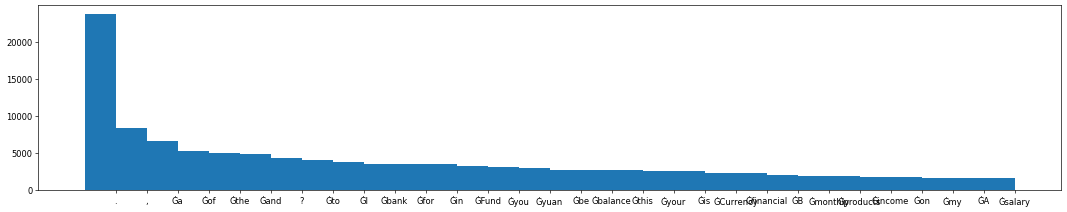

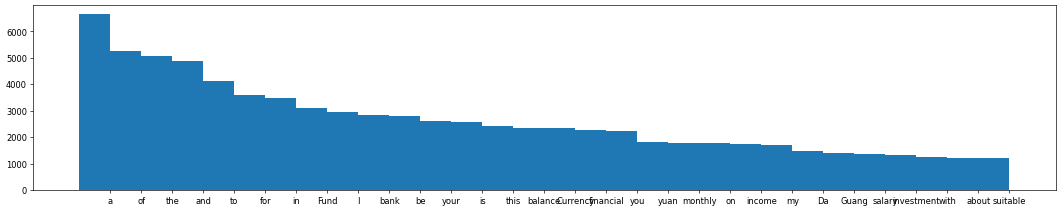

In [21]:
import matplotlib.pyplot as plt
from collections import Counter

def get_counter_and_lens(data, tokenizer):
    flatten = lambda l: [item for sublist in l for item in sublist]
    toks = [tokenizer.tokenize(x) for x in data]
    return list(map(len, toks)), Counter(flatten(toks)), Counter(' '.join(data).split())

df = pd.concat([trn_df, val_df], axis=0)    # whole set of 2 dataframes
lens, tok_cnt, word_cnt = get_counter_and_lens(trn_df[df.columns].apply(lambda x: ' '.join(x.astype(str)), axis = 1), tokenizer)

def plot_counts(counts, top_k = 30):
    labels, values = zip(*counts.most_common()[:top_k])

    indexes = np.arange(len(labels))
    width = 1
    plt.figure(num=None, figsize=(22, 4), dpi=60, facecolor='w', edgecolor='k')
    plt.bar(indexes, values, width)
    plt.xticks(indexes + width * 0.5, labels)
    plt.show()

plot_counts(tok_cnt, top_k = 30)
plot_counts(word_cnt, top_k = 30)

## Dataset Loader

In [15]:
from itertools import chain

''' Turn a List of str into a List of tokenized ID. Each sentence end with a special <EOS> sign '''

def construct_conv(row, tokenizer, eos=True):
    conv = [tokenizer.encode(x) + [tokenizer.eos_token_id] for x in reversed(row)]  # tokenize each element of a sentence
    conv_flat = list(chain.from_iterable(conv))    # to flat the nested list
    return conv_flat
'''
def construct_conv(row, tokenizer, eos = True):
    flatten = lambda l: [item for sublist in l for item in sublist]  # flatten is 
    conv = list(reversed([tokenizer.encode(x) + [tokenizer.eos_token_id] for x in row])) 
    conv = flatten(conv)
    return conv
'''

''' a self-defined PyTorch Dataset class to process conversation data 
df: DataFrame included conversation data
block_size: max size of each conversation instance '''
class ConversationDataset(Dataset):
    def __init__(self, tokenizer: PreTrainedTokenizer, args, df, block_size=512):
        self.tokenizer = tokenizer

        block_size = block_size - (tokenizer.model_max_length - tokenizer.max_len_single_sentence)

        directory = args.cache_dir
        cached_features_file = os.path.join(
            directory, args.model_type + "_cached_lm_" + str(block_size)
        )

        # if we have current cached features file, use directly
        # if not, store conversation data and create
        if os.path.exists(cached_features_file) and not args.overwrite_cache:
            logger.info("Loading features from cached file %s", cached_features_file)
            with open(cached_features_file, "rb") as handle:
                self.examples = pickle.load(handle)
        else:
            logger.info("Creating features from dataset file at %s", directory)

            self.examples = []
            for _, row in df.iterrows():
                conv = construct_conv(row, tokenizer)
                self.examples.append(conv)

            logger.info("Saving features into cached file %s", cached_features_file)
            with open(cached_features_file, "wb") as handle:
                pickle.dump(self.examples, handle, protocol=pickle.HIGHEST_PROTOCOL)

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, item):
        # get conversation instance from self.examples, turn into a PyTorch tensor and return
        return torch.tensor(self.examples[item], dtype=torch.long)

In [16]:
# Cacheing and storing of data/checkpoints

''' load and cache dataset examples
df_trn: DataFrame of train data
df_val: DataFrame of validate data '''
def load_and_cache_examples(args, tokenizer, df_trn, df_val, evaluate=False):
    return ConversationDataset(tokenizer, args, df_val if evaluate else df_trn)


def set_seed(args):
    ''' respectfully set 3 kinds of random number generator seeds '''
    random.seed(args.seed)
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    if args.n_gpu > 0:
        torch.cuda.manual_seed_all(args.seed)


def _sorted_checkpoints(args, checkpoint_prefix="checkpoint", use_mtime=False) -> List[str]:
    ordering_and_checkpoint_path = []

    glob_checkpoints = glob.glob(os.path.join(args.output_dir, "{}-*".format(checkpoint_prefix)))

    for path in glob_checkpoints:
        if use_mtime:
            ordering_and_checkpoint_path.append((os.path.getmtime(path), path))
        else:
            regex_match = re.match(".*{}-([0-9]+)".format(checkpoint_prefix), path)
            if regex_match and regex_match.groups():
                ordering_and_checkpoint_path.append((int(regex_match.groups()[0]), path))

    checkpoints_sorted = sorted(ordering_and_checkpoint_path)
    checkpoints_sorted = [checkpoint[1] for checkpoint in checkpoints_sorted]
    return checkpoints_sorted


def _rotate_checkpoints(args, checkpoint_prefix="checkpoint", use_mtime=False) -> None:
    ''' delete old checkpoints if necessary '''
    if not args.save_total_limit:
        return
    if args.save_total_limit <= 0:
        return

    # Check if we should delete older checkpoint(s)
    checkpoints_sorted = _sorted_checkpoints(args, checkpoint_prefix, use_mtime)
    if len(checkpoints_sorted) <= args.save_total_limit:
        return

    number_of_checkpoints_to_delete = max(0, len(checkpoints_sorted) - args.save_total_limit)
    checkpoints_to_be_deleted = checkpoints_sorted[:number_of_checkpoints_to_delete]
    for checkpoint in checkpoints_to_be_deleted:
        logger.info("Deleting older checkpoint [{}] due to args.save_total_limit".format(checkpoint))
        shutil.rmtree(checkpoint)

In [17]:
trn_df

,response,context
0,"Based on the client's income and balance, this...",Does this individual have chance to invest in ...
1,Without knowing the monthly earnings and bank ...,"Considering the options available, is Ping An ..."
2,This investment idea could be too risky for th...,What if one buys Guang Da Currency Fund B sinc...
3,"According to evaluating, I think Nong Ye Stock...",Given that I earn approximately 79691.4079691....
4,I suggest avoiding this investment. It's too r...,"Considering my current salary (7465.83 rmb), w..."
...,...,...
4356,I'm so glad to help. After a thorough planning...,I have 97325.15 yuan saved up and earn 131924....
4357,I'd oppose for going for this option. It's too...,Considering my annual earnings of around 1233....
4358,"Yes, I think Guang Da Stock Fund C fits you we...",Given that I earn approximately 177357.1617735...
4359,I'm here to help. In my view Jian She Accident...,With a bank balance of 40169.88 yuan and a mon...


## Training and Evaluating

There will be quite a lot of code needed for training our model but don’t worry, everything should work as is, the main thing is to give the model the dataset in the right format.


In [18]:
def train(args, train_dataset, model: PreTrainedModel, tokenizer: PreTrainedTokenizer) -> Tuple[int, float]:
    """ Train the model.
    train_dataset: a ConversationDataset object of train dataset
    model: model waited for training """
    if args.local_rank in [-1, 0]:
        tb_writer = SummaryWriter()
    
    # set num of training batch on each gpu
    args.train_batch_size = args.per_gpu_train_batch_size * max(1, args.n_gpu)

    def collate(examples: List[torch.Tensor]):
        if tokenizer._pad_token is None:
            return pad_sequence(examples, batch_first=True)
        return pad_sequence(examples, batch_first=True, padding_value=tokenizer.pad_token_id)

    # choose appropriate sampler and dataloader
    train_sampler = RandomSampler(train_dataset) if args.local_rank == -1 else DistributedSampler(train_dataset)
    train_dataloader = DataLoader(
        train_dataset, sampler=train_sampler, batch_size=args.train_batch_size, collate_fn=collate, drop_last=True, num_workers=12
    )
    ''' batch_size: how many samples would be loaded in each batch;  
    collate_fn: function to let data in various length have same length finally;
    drop_last: whether to desert the last part of data less than batch_size (like a little remainder), to avoid influencing the fine-tune quality
    num_workers: num of processes using for data loading, to use more CPU to speed up the data preparation '''

    if args.max_steps > 0:
        t_total = args.max_steps
        args.num_train_epochs = args.max_steps // (len(train_dataloader) // args.gradient_accumulation_steps) + 1
    else:
        t_total = len(train_dataloader) // args.gradient_accumulation_steps * args.num_train_epochs

    model = model.module if hasattr(model, "module") else model  # Take care of distributed/parallel training
    model.resize_token_embeddings(len(tokenizer))
    # add_special_tokens_(model, tokenizer)


    # Prepare optimizer and schedule (linear warmup and decay)
    no_decay = ["bias", "LayerNorm.weight"]
    optimizer_grouped_parameters = [
        {
            "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
            "weight_decay": args.weight_decay,
        },
        {"params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], "weight_decay": 0.0},
    ]
    optimizer = AdamW(optimizer_grouped_parameters, lr=args.learning_rate, eps=args.adam_epsilon)
    scheduler = get_linear_schedule_with_warmup(
        optimizer, num_warmup_steps=args.warmup_steps, num_training_steps=t_total
    )

    # Check if saved optimizer or scheduler states exist
    if (
        args.model_name_or_path
        and os.path.isfile(os.path.join(args.model_name_or_path, "optimizer.pt"))
        and os.path.isfile(os.path.join(args.model_name_or_path, "scheduler.pt"))
    ):
        # Load in optimizer and scheduler states
        optimizer.load_state_dict(torch.load(os.path.join(args.model_name_or_path, "optimizer.pt")))
        scheduler.load_state_dict(torch.load(os.path.join(args.model_name_or_path, "scheduler.pt")))

    if args.fp16:
        try:
            from apex import amp
        except ImportError:
            raise ImportError("Please install apex from https://www.github.com/nvidia/apex to use fp16 training.")
        model, optimizer = amp.initialize(model, optimizer, opt_level=args.fp16_opt_level)

    # multi-gpu training (should be after apex fp16 initialization)
    if args.n_gpu > 1:
        model = torch.nn.DataParallel(model)

    # Distributed training (should be after apex fp16 initialization)
    if args.local_rank != -1:
        model = torch.nn.parallel.DistributedDataParallel(
            model, device_ids=[args.local_rank], output_device=args.local_rank, find_unused_parameters=True
        )

    # Train!
    logger.info("***** Running training *****")
    logger.info("  Num examples = %d", len(train_dataset))
    logger.info("  Num Epochs = %d", args.num_train_epochs)
    logger.info("  Instantaneous batch size per GPU = %d", args.per_gpu_train_batch_size)
    logger.info(
        "  Total train batch size (w. parallel, distributed & accumulation) = %d",
        args.train_batch_size
        * args.gradient_accumulation_steps
        * (torch.distributed.get_world_size() if args.local_rank != -1 else 1),
    )
    logger.info("  Gradient Accumulation steps = %d", args.gradient_accumulation_steps)
    logger.info("  Total optimization steps = %d", t_total)

    global_step = 0
    epochs_trained = 0
    steps_trained_in_current_epoch = 0
    # Check if continuing training from a checkpoint
    if args.model_name_or_path and os.path.exists(args.model_name_or_path):
        try:
            # set global_step to gobal_step of last saved checkpoint from model path
            checkpoint_suffix = args.model_name_or_path.split("-")[-1].split("/")[0]
            global_step = int(checkpoint_suffix)
            epochs_trained = global_step // (len(train_dataloader) // args.gradient_accumulation_steps)
            steps_trained_in_current_epoch = global_step % (len(train_dataloader) // args.gradient_accumulation_steps)

            logger.info("  Continuing training from checkpoint, will skip to saved global_step")
            logger.info("  Continuing training from epoch %d", epochs_trained)
            logger.info("  Continuing training from global step %d", global_step)
            logger.info("  Will skip the first %d steps in the first epoch", steps_trained_in_current_epoch)
        except ValueError:
            logger.info("  Starting fine-tuning.")

    tr_loss, logging_loss = 0.0, 0.0

    model.zero_grad()
    train_iterator = trange(
        epochs_trained, int(args.num_train_epochs), desc="Epoch", disable=args.local_rank not in [-1, 0]
    )
    set_seed(args)  # Added here for reproducibility
    for _ in train_iterator:
        epoch_iterator = tqdm(train_dataloader, desc="Iteration", disable=args.local_rank not in [-1, 0])
        for step, batch in enumerate(epoch_iterator):

            # Skip past any already trained steps if resuming training
            if steps_trained_in_current_epoch > 0:
                steps_trained_in_current_epoch -= 1
                continue

            inputs, labels = (batch, batch)
            if inputs.shape[1] > 1024: continue
            inputs = inputs.to(args.device)
            labels = labels.to(args.device)
            model.train()
            outputs = model(inputs, labels=labels)
            loss = outputs[0]  # model outputs are always tuple in transformers (see doc)

            if args.n_gpu > 1:
                loss = loss.mean()  # mean() to average on multi-gpu parallel training
            if args.gradient_accumulation_steps > 1:
                loss = loss / args.gradient_accumulation_steps

            if args.fp16:
                with amp.scale_loss(loss, optimizer) as scaled_loss:
                    scaled_loss.backward()
            else:
                loss.backward()

            tr_loss += loss.item()
            if (step + 1) % args.gradient_accumulation_steps == 0:
                if args.fp16:
                    torch.nn.utils.clip_grad_norm_(amp.master_params(optimizer), args.max_grad_norm)
                else:
                    torch.nn.utils.clip_grad_norm_(model.parameters(), args.max_grad_norm)
                optimizer.step()
                scheduler.step()  # Update learning rate schedule
                model.zero_grad()
                global_step += 1

                if args.local_rank in [-1, 0] and args.logging_steps > 0 and global_step % args.logging_steps == 0:
                    # Log metrics
                    if (
                        args.local_rank == -1 and args.evaluate_during_training
                    ):  # Only evaluate when single GPU otherwise metrics may not average well
                        results = evaluate(args, model, tokenizer)
                        for key, value in results.items():
                            tb_writer.add_scalar("eval_{}".format(key), value, global_step)
                    tb_writer.add_scalar("lr", scheduler.get_lr()[0], global_step)
                    tb_writer.add_scalar("loss", (tr_loss - logging_loss) / args.logging_steps, global_step)
                    logging_loss = tr_loss

                if args.local_rank in [-1, 0] and args.save_steps > 0 and global_step % args.save_steps == 0:
                    checkpoint_prefix = "checkpoint"
                    # Save model checkpoint
                    output_dir = os.path.join(args.output_dir, "{}-{}".format(checkpoint_prefix, global_step))
                    os.makedirs(output_dir, exist_ok=True)
                    model_to_save = (
                        model.module if hasattr(model, "module") else model
                    )  # Take care of distributed/parallel training
                    model_to_save.save_pretrained(output_dir)
                    tokenizer.save_pretrained(output_dir)

                    torch.save(args, os.path.join(output_dir, "training_args.bin"))
                    logger.info("Saving model checkpoint to %s", output_dir)

                    _rotate_checkpoints(args, checkpoint_prefix)

                    torch.save(optimizer.state_dict(), os.path.join(output_dir, "optimizer.pt"))
                    torch.save(scheduler.state_dict(), os.path.join(output_dir, "scheduler.pt"))
                    logger.info("Saving optimizer and scheduler states to %s", output_dir)

            if args.max_steps > 0 and global_step > args.max_steps:
                epoch_iterator.close()
                break
        if args.max_steps > 0 and global_step > args.max_steps:
            train_iterator.close()
            break

    if args.local_rank in [-1, 0]:
        tb_writer.close()

    return global_step, tr_loss / global_step

# Evaluation of some model

def evaluate(args, model: PreTrainedModel, tokenizer: PreTrainedTokenizer, df_trn, df_val, prefix="") -> Dict:
    # Loop to handle MNLI double evaluation (matched, mis-matched)
    eval_output_dir = args.output_dir

    eval_dataset = load_and_cache_examples(args, tokenizer, df_trn, df_val, evaluate=True)
    os.makedirs(eval_output_dir, exist_ok=True)
    args.eval_batch_size = args.per_gpu_eval_batch_size * max(1, args.n_gpu)
    # Note that DistributedSampler samples randomly

    def collate(examples: List[torch.Tensor]):
        if tokenizer._pad_token is None:
            return pad_sequence(examples, batch_first=True)
        return pad_sequence(examples, batch_first=True, padding_value=tokenizer.pad_token_id)

    eval_sampler = SequentialSampler(eval_dataset)
    eval_dataloader = DataLoader(
        eval_dataset, sampler=eval_sampler, batch_size=args.eval_batch_size, collate_fn=collate, drop_last = True
    )

    # multi-gpu evaluate
    if args.n_gpu > 1:
        model = torch.nn.DataParallel(model)

    # Eval!
    logger.info("***** Running evaluation {} *****".format(prefix))
    logger.info("  Num examples = %d", len(eval_dataset))
    logger.info("  Batch size = %d", args.eval_batch_size)
    eval_loss = 0.0
    nb_eval_steps = 0
    model.eval()       # set model into eval mode

    for batch in tqdm(eval_dataloader, desc="Evaluating"):
        inputs, labels = (batch, batch)
        inputs = inputs.to(args.device)
        labels = labels.to(args.device)

        with torch.no_grad():
            outputs = model(inputs, labels=labels)
            lm_loss = outputs[0]
            eval_loss += lm_loss.mean().item()
        nb_eval_steps += 1

    eval_loss = eval_loss / nb_eval_steps
    perplexity = torch.exp(torch.tensor(eval_loss))

    result = {"perplexity": perplexity}

    output_eval_file = os.path.join(eval_output_dir, prefix, "eval_results.txt")
    with open(output_eval_file, "w") as writer:
        logger.info("***** Eval results {} *****".format(prefix))
        for key in sorted(result.keys()):
            logger.info("  %s = %s", key, str(result[key]))
            writer.write("%s = %s\n" % (key, str(result[key])))

    return result

In [19]:
import os
import logging
import glob
import torch
from transformers import AutoConfig, AutoTokenizer, AutoModelForCausalLM

def main(df_trn, df_val):
    args = Args()
    
    if args.should_continue:
        # if True, find the newest checkpoint and start training from there
        sorted_checkpoints = _sorted_checkpoints(args)
        if len(sorted_checkpoints) == 0:
            raise ValueError("Used --should_continue but no checkpoint was found in --output_dir.")
        else:
            args.model_name_or_path = sorted_checkpoints[-1]

    if (
        os.path.exists(args.output_dir)   # output dir has been appointed and not empty
        and os.listdir(args.output_dir)
        and args.do_train
        and not args.overwrite_output_dir
        and not args.should_continue      # load model from the newest checkpoint
    ):
        raise ValueError(
            "Output directory ({}) already exists and is not empty. Use --overwrite_output_dir to overcome.".format(
                args.output_dir
            )
        )

    # Setup CUDA, GPU & distributed training
    # instead of directly set 'args.n_gpu = 1', we can dynamically deliver GPUs according to how many we have
    args.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    args.n_gpu = torch.cuda.device_count() if torch.cuda.is_available() else 0

    # Setup logging to record key info in training process
    logging.basicConfig(
        format="%(asctime)s - %(levelname)s - %(name)s -   %(message)s",
        datefmt="%m/%d/%Y %H:%M:%S",
        level=logging.INFO if args.local_rank in [-1, 0] else logging.WARN,
    )
    logger.warning(
        "Process rank: %s, device: %s, n_gpu: %s, distributed training: %s, 16-bits training: %s",
        args.local_rank,
        args.device,
        args.n_gpu,
        bool(args.local_rank != -1),
        args.fp16,
    )

    # Set seed
    set_seed(args)

    config = AutoConfig.from_pretrained(args.config_name, cache_dir=args.cache_dir)
    tokenizer = AutoTokenizer.from_pretrained(args.tokenizer_name, cache_dir=args.cache_dir)
    model = AutoModelForCausalLM.from_pretrained(
        args.model_name_or_path,
        from_tf=False,
        config=config,
        cache_dir=args.cache_dir,
    )
    model.to(args.device)
    
    logger.info("Training/evaluation parameters %s", args)

    # Training
    if args.do_train:
        train_dataset = load_and_cache_examples(args, tokenizer, df_trn, df_val, evaluate=False)
        global_step, tr_loss = train(args, train_dataset, model, tokenizer)
        logger.info(" global_step = %s, average loss = %s", global_step, tr_loss)

    # Saving best-practices: if using save_pretrained for the model and tokenizer, we can reload them using from_pretrained()
    # Or we have no need to reload them again, since they are just in their newest verisons in this stage
    if args.do_train:
        # Create output directory if needed
        os.makedirs(args.output_dir, exist_ok=True)

        logger.info("Saving model checkpoint to %s", args.output_dir)
        model_to_save = (
            model.module if hasattr(model, "module") else model
        )
        model_to_save.save_pretrained(args.output_dir)
        tokenizer.save_pretrained(args.output_dir)
        torch.save(args, os.path.join(args.output_dir, "training_args.bin"))
        ''' To invoke on PC local, model file like pytorch_model.bin is required, but somehow only model.safetensors is saved previously,
        so here we manually add pytorch_model.bin into the same output dir '''
        torch.save(model.state_dict(), os.path.join(args.output_dir, "pytorch_model.bin"))

        model.to(args.device)

    # Evaluation
    results = {}
    if args.do_eval and args.local_rank in [-1, 0]:
        checkpoints = [args.output_dir]
        if args.eval_all_checkpoints:
            checkpoints = list(
                os.path.dirname(c) for c in sorted(glob.glob(args.output_dir + "/**/" + WEIGHTS_NAME, recursive=True))
            )
            logging.getLogger("transformers.modeling_utils").setLevel(logging.WARN)
        logger.info("Evaluate the following checkpoints: %s", checkpoints)
        for checkpoint in checkpoints:
            global_step = checkpoint.split("-")[-1] if len(checkpoints) > 1 else ""
            prefix = checkpoint.split("/")[-1] if checkpoint.find("checkpoint") != -1 else ""

            model = AutoModelForCausalLM.from_pretrained(checkpoint)
            model.to(args.device)
            result = evaluate(args, model, tokenizer, df_trn, df_val, prefix=prefix)
            result = dict((k + "_{}".format(global_step), v) for k, v in result.items())
            results.update(result)
            
    return results

In [20]:
main(trn_df, val_df)

04/30/2024 01:45:03 - WARNING - __main__ -   Process rank: -1, device: cuda, n_gpu: 1, distributed training: False, 16-bits training: False


config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.75G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

04/30/2024 01:45:24 - INFO - __main__ -   Training/evaluation parameters <__main__.Args object at 0x7f2da54a01f0>
04/30/2024 01:45:24 - INFO - __main__ -   Creating features from dataset file at cached
/tmp/ipykernel_111/3152893217.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  conv = [tokenizer.encode(x) + [tokenizer.eos_token_id] for x in reversed(row)]  # tokenize each element of a sentence
04/30/2024 01:45:26 - INFO - __main__ -   Saving features into cached file cached/gpt2_cached_lm_512
/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Iteration:   0%|          | 0/2180 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Iteration:   0%|          | 0/2180 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Iteration:   0%|          | 0/2180 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Evaluating:   0%|          | 0/623 [00:00<?, ?it/s]

04/30/2024 02:02:01 - INFO - __main__ -   ***** Eval results  *****
04/30/2024 02:02:01 - INFO - __main__ -     perplexity = tensor(1.4878)


{'perplexity_': tensor(1.4878)}

## Generate test results


In [21]:
f_test = open(test_data)
test_data = json.load(f_test)
f_test.close()

# asked by user
test_query = []
# answered by LLM
test_response = []

for i in range(len(test_data)):
  test_response.append(test_data[i][1])   # the 2nd element in a data unit is the reference response
  test_query.append(test_data[i][0])      # the 1st element in a data unit is the query (prompt)

print(len(test_response))
print(len(test_query))

623
623


In [22]:
#def check_correctness(predict):
    

In [23]:
"""
from transformers import AutoTokenizer, AutoModelForCausalLM

test_chatbot = []

#for i in range(len(test_query)):
for i in range(6):
  tokenizer = AutoTokenizer.from_pretrained('microsoft/DialoGPT-large', padding_side='left')
  model = AutoModelForCausalLM.from_pretrained('output-small-save')
    
  query = input("User:")
    
  # encode each query as a token ID, add a sign <EOS>, output is a PyTorch tensor
  bot_input_ids = tokenizer.encode(query + tokenizer.eos_token, return_tensors='pt')
  print("User: {} \n".format(query))

  # generated a response while limiting the total chat history to 1000 tokens, 
  chat_history_ids = model.generate(
      bot_input_ids, max_length=100,
      pad_token_id=tokenizer.eos_token_id,  
      no_repeat_ngram_size=3,       
      do_sample=True, 
      top_k=10, 
      top_p=0.7,
      temperature = 0.8
  )

  # pretty print last ouput tokens from bot
  # decode the response stored in 'chat_history_ids' into readable text, skip 'beginning','ending',...
  predict = tokenizer.decode(chat_history_ids[:, bot_input_ids.shape[-1]:][0], skip_special_tokens=True)
  print("Predict: {} \n\n".format(predict))
  test_chatbot.append(predict)

print(len(test_chatbot))"""

'\nfrom transformers import AutoTokenizer, AutoModelForCausalLM\n\ntest_chatbot = []\n\n#for i in range(len(test_query)):\nfor i in range(6):\n  tokenizer = AutoTokenizer.from_pretrained(\'microsoft/DialoGPT-large\', padding_side=\'left\')\n  model = AutoModelForCausalLM.from_pretrained(\'output-small-save\')\n    \n  query = input("User:")\n    \n  # encode each query as a token ID, add a sign <EOS>, output is a PyTorch tensor\n  bot_input_ids = tokenizer.encode(query + tokenizer.eos_token, return_tensors=\'pt\')\n  print("User: {} \n".format(query))\n\n  # generated a response while limiting the total chat history to 1000 tokens, \n  chat_history_ids = model.generate(\n      bot_input_ids, max_length=100,\n      pad_token_id=tokenizer.eos_token_id,  \n      no_repeat_ngram_size=3,       \n      do_sample=True, \n      top_k=10, \n      top_p=0.7,\n      temperature = 0.8\n  )\n\n  # pretty print last ouput tokens from bot\n  # decode the response stored in \'chat_history_ids\' into r

In [24]:

tokenizer = AutoTokenizer.from_pretrained('microsoft/DialoGPT-large', padding_side='left')
model = AutoModelForCausalLM.from_pretrained(output_dir)

test_chatbot = []

for i in range(6):
    
    # encode each query as a token ID, add a sign <EOS>, output is a PyTorch tensor
    bot_input_ids = tokenizer.encode(test_query[i] + tokenizer.eos_token, return_tensors='pt')
    
    print("User: {} \n".format(test_query[i]))
    print("Reference:  {} \n".format(test_response[i]))

    # generated a response while limiting the total chat history to 1000 tokens, 
    chat_history_ids = model.generate(
        bot_input_ids, max_length=100,
        pad_token_id=tokenizer.eos_token_id,
        no_repeat_ngram_size=3,       
        do_sample=True, 
        top_k=10, 
        top_p=0.7,
        temperature = 0.8
    )

    # pretty print last ouput tokens from bot
    # decode the response stored in 'chat_history_ids' into readable text, skip 'beginning','ending',...
    predict = tokenizer.decode(chat_history_ids[:, bot_input_ids.shape[-1]:][0], skip_special_tokens=True)
    print("Predict: {} \n\n".format(predict))
    test_chatbot.append(predict)
    

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


User: Help me select appropriate bank products. If I make 174205.22 yuan each month and have a balance of 0.00 RMB. 

Reference:  Considering the details shared, Xing Ye Debenture A stands out as a promising option for you. 



A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Predict: After assessing your situation, Xing Ye Debenture A looks like a strong candidate for your consideration. 


User: If the monthly income is 48179.17 yuan and the bank balance is 7360 yuan, someone might be looking for advice on investing in bank products. Can recommendations be offered? 

Reference:  Considering the balance and earnings of this user, there are no suitable options available; all present too much risk for him / her. 



A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Predict: Regrettably, there are no products that match the balance and salary of this one. 


User: I wonder if it's a good idea for me to buy Guang Da Currency Fund B given my current salary (9536.67￥ per month) and savings (RMB 931). What do you think? 

Reference:  I suggest against purchasing this product. It has to much potential cost for loss given your financial circumstances. 



A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Predict: Based on your income and balance, I don't think Guang Da currency Fund B is one of the suitable options for you. I recommend exploring safer investment opportunities with lower risk. 


User: Can you tell me on which bank products to consider? 

Reference:  Sure, firstly I need to know your saving and monthly salary. 



A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Predict: For sure, I need some information about your finances first. Share details with me about your income and saving. 


User: I've deposited 0.00 yuan in my bank account. With an annual income of around 170307.43170307.43170307.43170307.43170307.43170307.43170307.43170307.43170307.43170307.43170307.43170307.43 yuan, I'm seeking advice on available purchase options. 

Reference:  Let's take a look... How about Gong Shang Stock Fund A? It's a Stock Fund that could suit your needs. 



A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Predict: It's my pleasure to serve you. After examining the details, I recommend considering Ping An Currency Fund A as 


User: Help me select appropriate bank products. If I make 1910.83 yuan each month and have a balance of 13547 RMB. 

Reference:  Considering your savings and income, there are nothing available here for you —— they all carry too much risk. 

Predict: I'm sorry, but due to your poor financial condition, I'm unable to recommend any products for you. 




## Test and evaluate on various size of test set


In [25]:
"""
import re

''' Various bank products '''

# Currency Fund
part_I = [["Ping An Currency Fund A","Currency Fund",12000],
          ["Guang Da Currency Fund B","Currency Fund",16500],
          ["Zhao Shang Currency Fund C","Currency Fund",20000]]
# Insurance
part_II = [
    ["Gong Shang Medical Insurance A", "Medical Insurance", 35000],
    ["Zhong Xin Medical Insurance B", "Medical Insurance", 39000],
    ["Ping An Medical Insurance C", "Medical Insurance", 44000],
    ["Hua Xia Accidental Insurance A", "Accidental Insurance", 36000],
    ["Jian She Accidental Insurance B", "Accidental Insurance", 39000],
    ["Nong Ye Accidental Insurance C", "Accidental Insurance", 42000],
]
# Stock Fund
part_III = [
    ["Gong Shang Stock Fund A", "Stock Fund", 59000],
    ["Nong Ye Stock Fund B", "Stock Fund", 64000],
    ["Guang Da Stock Fund C", "Stock Fund", 70000],
]
# Debenture
part_IV = [
    ["Xing Ye Debenture A", "Debenture", 80000],
    ["Chong Qing Debenture B", "Debenture", 84000],
    ["Zhong Xin Debenture C", "Debenture", 89000],
]

parts = [part_I, part_II, part_III, part_IV]
product_names = []
for part in parts:
    for unit in part:
        product_names.append(unit[0])

# Key words
key_words_negative = ['sorry', 'poor financial', r'too much .*risk', r'no .*available', r'no. *recommend', 'unsafe', r'no .*safe',
                      'regret', r'no .*choice', 'unfortunately', 'excessive risk', 'risky', 'fail', r'no .*feasible', r'no .*available', 'no '+r'.*suitable', r'much.*loss', 'against'
                      r'no .*safe', 'fragile', 'dangerous', 'failure', 'not', 'aren\'t', 'don\'t', 'can\'t', 'couldn\'t', 'unable', r'risk.*too.*high',
                      r'no .*choice', r'no .*option', 'regrettably', r'too .*weak', ]

limits = [100, 200, 300, 400]

''' Classify different parts from datasets '''

test_data_huge = datasets_dir + '/test_data_huge.json'
f_test_huge = open(test_data_huge)
test_data_huge = json.load(f_test_huge)
f_test_huge.close()

query = []
response = []
conversation_type = []
attitude = []

for i in range(len(test_data_huge)):
  response.append(test_data_huge[i][1])            # the 2nd element in a data unit is the reference response
  query.append(test_data_huge[i][0])               # the 1st element in a data unit is the query (prompt)
  conversation_type.append(test_data_huge[i][2])   # the 3rd element in a data unit is the type of the conversation (e.g. ask, recommend, evaluate, ...)
  attitude.append(test_data_huge[i][3])            # the 1st element in a data unit is the attitude (e.g. positive, negative, ...)


def judge(conversation_type, attitude, predict):
    ''' Return 'Y' if model gives a reasonable answer, and 'N' if not.
    My samples used here are all about clear attitude (support / oppose), without unclear. '''
    
    if conversation_type == 'recommend':
        for name in product_names:
            if name in predict:
                # a name of product can be found in the answer of model, means only one thing: it is doing recommendation
                if attitude == 'positive':
                    return 'Y'
                else:
                    return 'N'
        # didn't find, so the model did not recommend any products, in other words it refusesd
        if attitude == 'positive':
            return 'N'
        else:
            return 'Y'
    
    elif conversation_type == 'evaluate':
        sentiment = 'positive'
        for word in key_words_negative:
            if re.search(word, predict):
                sentiment = 'negative'
        if sentiment == attitude:
            return 'Y'
        else:
            return 'N'
        
    
''' Do chat with model, collect responses, analyze them to know if it is reasonable '''

num_of_success = 0
num_of_failure = 0

print('Size of train data:\t'+str(len(train_data)))

tokenizer = AutoTokenizer.from_pretrained('microsoft/DialoGPT-large', padding_side='left')
model = AutoModelForCausalLM.from_pretrained(output_dir)

for i in range(len(query)):
    # encode each query as a token ID, add a sign <EOS>, output is a PyTorch tensor
    bot_input_ids = tokenizer.encode(test_query[i] + tokenizer.eos_token, return_tensors='pt')

    # generated a response while limiting the total chat history to 1000 tokens, 
    chat_history_ids = model.generate(
      bot_input_ids, max_length=200,
      pad_token_id=tokenizer.eos_token_id,
      no_repeat_ngram_size=3,       
      do_sample=True, 
      top_k=10, 
      top_p=0.7,
      temperature = 0.8
    )

    # decode the response stored in 'chat_history_ids' into readable text, skip 'beginning','ending',...
    predict = tokenizer.decode(chat_history_ids[:, bot_input_ids.shape[-1]:][0], skip_special_tokens=True)

    if judge(conversation_type[i], attitude[i], predict) == 'Y':
        num_of_success += 1
    else:
        num_of_failure += 1
    
    for limit in limits:
        if i+1 == limit:
            print('Num: '+str(i+1)+'\tSuccess: '+str(num_of_success)+'\tFailure:\t'+str(num_of_failure)+'\tAccuracy: '+str(num_of_success/len(query)))
    
    print('round'+str(i)+', '+'\tSuccess: '+str(num_of_success)+'\tFailure: '+str(num_of_failure), end='')
    
print('Num: '+str(len(query))+'\tSuccess: '+str(num_of_success)+'\tFailure:\t'+str(num_of_failure))"""

'\nimport re\n\n\'\'\' Various bank products \'\'\'\n\n# Currency Fund\npart_I = [["Ping An Currency Fund A","Currency Fund",12000],\n          ["Guang Da Currency Fund B","Currency Fund",16500],\n          ["Zhao Shang Currency Fund C","Currency Fund",20000]]\n# Insurance\npart_II = [\n    ["Gong Shang Medical Insurance A", "Medical Insurance", 35000],\n    ["Zhong Xin Medical Insurance B", "Medical Insurance", 39000],\n    ["Ping An Medical Insurance C", "Medical Insurance", 44000],\n    ["Hua Xia Accidental Insurance A", "Accidental Insurance", 36000],\n    ["Jian She Accidental Insurance B", "Accidental Insurance", 39000],\n    ["Nong Ye Accidental Insurance C", "Accidental Insurance", 42000],\n]\n# Stock Fund\npart_III = [\n    ["Gong Shang Stock Fund A", "Stock Fund", 59000],\n    ["Nong Ye Stock Fund B", "Stock Fund", 64000],\n    ["Guang Da Stock Fund C", "Stock Fund", 70000],\n]\n# Debenture\npart_IV = [\n    ["Xing Ye Debenture A", "Debenture", 80000],\n    ["Chong Qing Deben

In [26]:
'''
model.save_pretrained('./model')
tokenizer.save_pretrained('./model')
'''

"\nmodel.save_pretrained('./model')\ntokenizer.save_pretrained('./model')\n"